<h1 style='color:white; background:black; border:0'><center>Post Similarity Analyzer (GENSIM TF-IDF + RAPIDS KNN)</center></h1>

![](https://storage.googleapis.com/kaggle-datasets-images/1226967/2048152/b7b21a6c2113257ec9ddf7221abfed1a/dataset-cover.png?t=2021-03-23-12-43-24)

<h3 style='color:white; background:black; border:0'><center>This dataset includes over 500,000 posts from 19 Date Science subreddits:</center></h3>

[r/analytics](https://www.reddit.com/r/analytics/), [r/deeplearning](https://www.reddit.com/r/deeplearning/), [r/datascience](https://www.reddit.com/r/datascience/), [r/datasets](https://www.reddit.com/r/datasets/), [r/kaggle](https://www.reddit.com/r/kaggle/), [r/learnmachinelearning](https://www.reddit.com/r/learnmachinelearning/), [r/MachineLearning](https://www.reddit.com/r/MachineLearning/), [r/statistics](https://www.reddit.com/r/statistics/), [r/artificial](https://www.reddit.com/r/artificial/), [r/AskStatistics](https://www.reddit.com/r/AskStatistics/), [r/computerscience](https://www.reddit.com/r/computerscience/), [r/computervision](https://www.reddit.com/r/computervision/), [r/dataanalysis](https://www.reddit.com/r/dataanalysis/), [r/dataengineering](https://www.reddit.com/r/dataengineering/), [r/DataScienceJobs](https://www.reddit.com/r/DataScienceJobs/), [r/datascienceproject](https://www.reddit.com/r/datascienceproject/), [r/data](https://www.reddit.com/r/data/), [r/MLQuestions](https://www.reddit.com/r/MLQuestions/), [r/rstats](https://www.reddit.com/r/rstats/)

Data were collected from [pushshift.io API](https://pushshift.io) (maintained by Jason Baumgartner).

<h3 style='color:white; background:black; border:0'><center>19 datasets (one per one subreddit) include the following data:</center></h3>

`#` - row index;
`created_date` - post publication date;
`created_timestamp` - post publication timestamp;
`subreddit` - subreddit name;
`title` - post title;
`id` - unique operation id;
`author` - post author;
`author_created_utc` - author registration date;
`full_link` - hyperlink to post;
`score` - ratio of likes and dislikes;
`num_comments` - the number of comments;
`num_crossposts` - the number of crossposts; 
`subreddit_subscribers` - the number of subreddit subscribers at the time the post was published;
`post` - post text.

**If you are interested, see**
- [this dataset (Reddit Data Science Posts)](https://www.kaggle.com/maksymshkliarevskyi/reddit-data-science-posts) 
- [first notebook (How is Data Science on Reddit? (EDA, RAPIDS))](https://www.kaggle.com/maksymshkliarevskyi/how-is-data-science-on-reddit-eda-rapids#RAPIDS-and-post-title).

Feel free to leave your comments on this notebook. I will try to make dataset better and much larger.

<h2 style='color:white; background:black; border:0'><center>Work Motivation</center></h2>

The first thing that comes to mind (to me personally) when looking at a fairly large database with posts is checking their similarity. We already tried to do this in the first notebook ([How is Data Science on Reddit? (EDA, RAPIDS)](https://www.kaggle.com/maksymshkliarevskyi/how-is-data-science-on-reddit-eda-rapids#RAPIDS-and-post-title), but we ran into the problem of insufficient memory when training the RAPIDS KNN model. Not surprisingly, because we used a dense matrix, which takes up a LOT of memory. Instead, it makes sense to use a sparse matrix. Since sklearn knn does not support GPU computation, we will again use RAPIDS to speed up computations.

Great, 500,000 posts shouldn't be a problem for this approach. But just looking at the similarities is interesting, but not entirely practical. A more professional approach is to create an analyzer of new posts that will find posts in the database that are most similar to them.

This notebook will be dedicated to the solution of this problem.

# Load Libraries and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, unicodedata, string
import pandas as pd
import tqdm
from tqdm.auto import tqdm as tqdmp
tqdmp.pandas()

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2csc

from cuml.neighbors import NearestNeighbors

from joblib import dump, load

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

# Some settings for visualizations
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 
            'xtick.color': 'white', 'ytick.color': 'white', 
            'grid.color': 'white', 'axes.labelcolor': 'white',
            'figure.dpi': 150, 'grid.linestyle': ':', 'grid.alpha': .6,
            'font.family': 'fantasy'})

In [2]:
all_data = pd.read_csv('../input/reddit-data-science-posts/reddit_database.csv')
all_data['created_date'] = all_data['created_date'].astype('datetime64')
all_data.head()

,created_date,created_timestamp,subreddit,title,id,author,author_created_utc,full_link,score,num_comments,num_crossposts,subreddit_subscribers,post
0,2010-02-10 22:06:17,1.265832e+09,analytics,YouTube's traffic data for music questioned,b0ih7,salvage,1.184143e+09,https://www.reddit.com/r/analytics/comments/b0...,3.0,0.0,0.0,NaN,NaN
1,2010-02-10 22:06:53,1.265832e+09,analytics,November Sees Number of U.S. Videos Viewed Onl...,b0ihf,salvage,1.184143e+09,https://www.reddit.com/r/analytics/comments/b0...,1.0,0.0,0.0,NaN,NaN
2,2010-02-11 19:47:22,1.265910e+09,analytics,So what do you guys all do related to analytic...,b0x63,xtom,1.227476e+09,https://www.reddit.com/r/analytics/comments/b0...,7.0,4.0,0.0,NaN,There's a lot of reasons to want to know all t...
3,2010-02-12 18:10:36,1.265991e+09,analytics,10 Web Analytics Tools For Tracking Your Visitors,b1bbg,[deleted],NaN,https://www.reddit.com/r/analytics/comments/b1...,4.0,1.0,0.0,NaN,NaN
4,2010-02-26 20:26:18,1.267209e+09,analytics,Improving Your Sense of Site,b6x0n,[deleted],NaN,https://www.reddit.com/r/analytics/comments/b6...,2.0,0.0,0.0,NaN,NaN


# Necessary functions

In [3]:
def text_cleaner(text):
    """
    Function for cleaning text data from unnecessary characters.
    """
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def knn_viz(rows, k_neighbors = 15):
    for i in rows:
        plt.figure(figsize = (20, 3))
        plt.plot(np.arange(k_neighbors), 
                 distances[i, :k_neighbors], 'o--', 
                 color = 'red', linewidth = 3, markersize = 12)
        plt.title('Text Distance From Row %i to Other Rows'%i, 
                  size = 16, color = 'white')
        plt.ylabel('Distance to Row %i'%i, size = 14)
        plt.xlabel('Index Sorted by Distance to Row %i'%i, size = 14)
        plt.show()

        print(all_data.loc[indices[i, :k_neighbors], 'title'])
        print()

# POST TITLES

## Data preprocessing

We will not do EDA, since it was already in the [first notebook](https://www.kaggle.com/maksymshkliarevskyi/how-is-data-science-on-reddit-eda-rapids#RAPIDS-and-post-title), and therefore we will immediately focus on completing the task.

Let's prepare our data for further work.

In [4]:
post_cleaned = all_data['title'].dropna().reset_index(drop = True)
post_cleaned = post_cleaned.progress_apply(lambda x: text_cleaner(x).split())
post_cleaned

  0%|          | 0/527646 [00:00<?, ?it/s]

0         [youtubes, traffic, data, for, music, questioned]
1         [november, sees, number, of, us, videos, viewe...
2         [so, what, do, you, guys, all, do, related, to...
3         [web, analytics, tools, for, tracking, your, v...
4                        [improving, your, sense, of, site]
                                ...                        
527641    [data, science, amp, data, analytics, ebooks, ...
527642    [how, to, extract, object, names, form, within...
527643         [plotting, an, ecdf, with, a, lot, of, data]
527644    [help, with, creating, a, custom, function, th...
527645    [showing, t, test, data, in, a, table, with, c...
Name: title, Length: 527646, dtype: object

And we will immediately generate several test titles that are slightly different from the original ones.

In [5]:
test_posts = post_cleaned[2:4].copy()
test_posts.iloc[0] = ['hi'] + test_posts.iloc[0]
test_posts.iloc[1] = ['great'] + test_posts.iloc[1]
test_posts

2    [hi, so, what, do, you, guys, all, do, related...
3    [great, web, analytics, tools, for, tracking, ...
Name: title, dtype: object

## TF-IDF Gensim

First, we need to create a dictionary, which will then be used to create the bag of words corpus.

In [6]:
dictionary = Dictionary(post_cleaned)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

In [7]:
# the bag of words corpus
corpus_bow = [dictionary.doc2bow(doc) for doc in post_cleaned]

Now the TF-IDF model itself. First, we train it, and then we extract the vector representations for all posts.

In [8]:
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

Finally, we create a sparse matrix with TF-IDF values.

It needs to be transposed to bring it to the form of posts * size of the dictionary

In [9]:
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms, num_docs=num_docs).T
corpus_tfidf_sparse

<527646x101304 sparse matrix of type '<class 'numpy.float64'>'
	with 4661393 stored elements in Compressed Sparse Row format>

Our matrix has the shape of 527646x101304. As mentioned, this is too much for a dense matrix.

## RAPIDS KNN

Let's fit our RAPIDS KNN model to find 5 nearest neighbors and then visualize the results with the familiar function.

In [10]:
model = NearestNeighbors(n_neighbors = 5)
model.fit(corpus_tfidf_sparse)

distances, indices = model.kneighbors(corpus_tfidf_sparse)

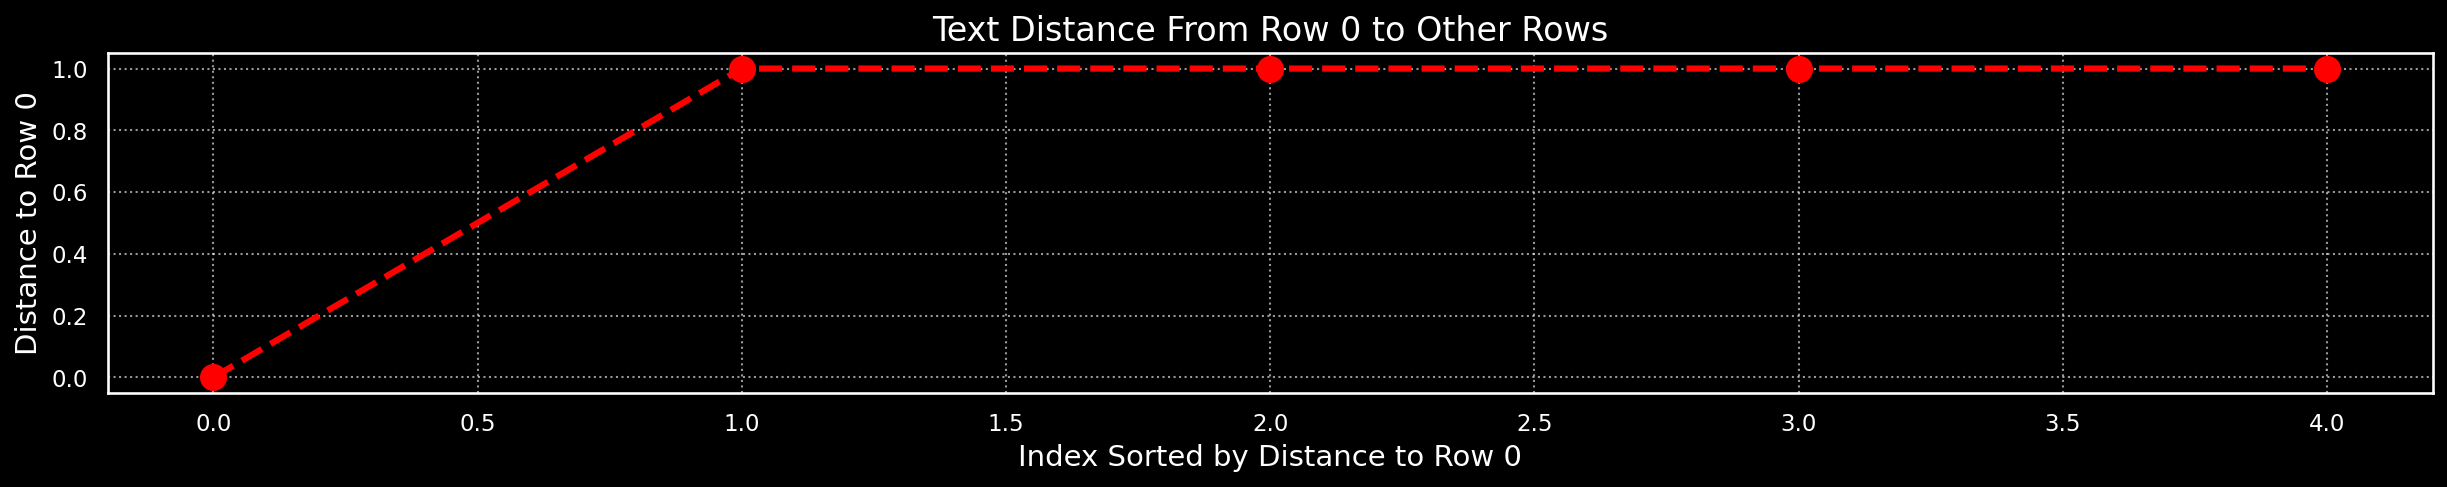

0               YouTube's traffic data for music questioned
524286                                                  ...
524748    https://filmi-beats.blogspot.com/2020/08/Haley...
525052                                         第三世多杰羌佛辦公室臉書
513589    http://stats.stackexchange.com/questions/14183...
Name: title, dtype: object



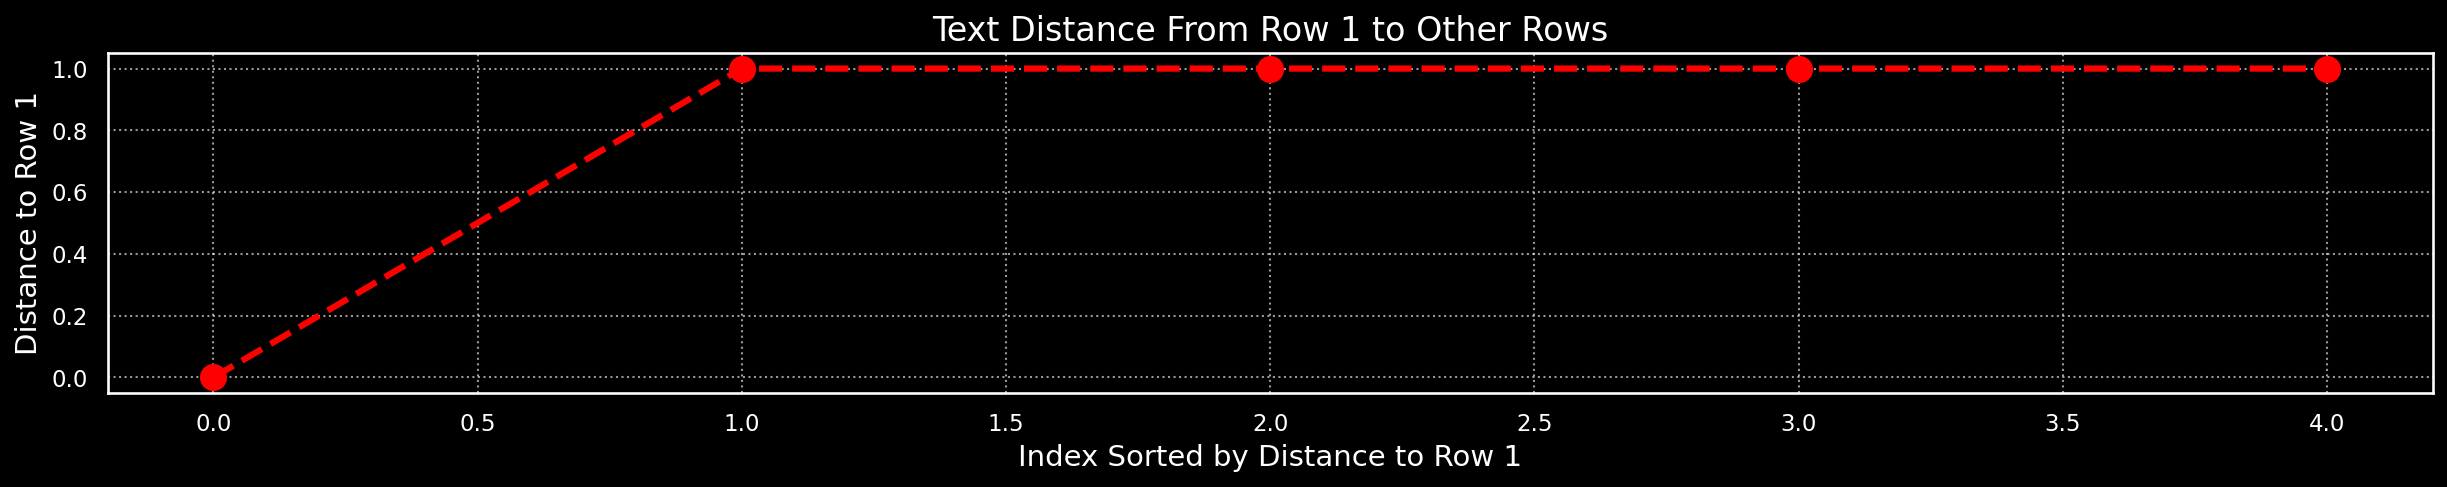

1         November Sees Number of U.S. Videos Viewed Onl...
523122    בן ממשיך בנחלה -בתי המשפט לא נותנים תשובות - ב...
524748    https://filmi-beats.blogspot.com/2020/08/Haley...
524286                                                  ...
513589    http://stats.stackexchange.com/questions/14183...
Name: title, dtype: object



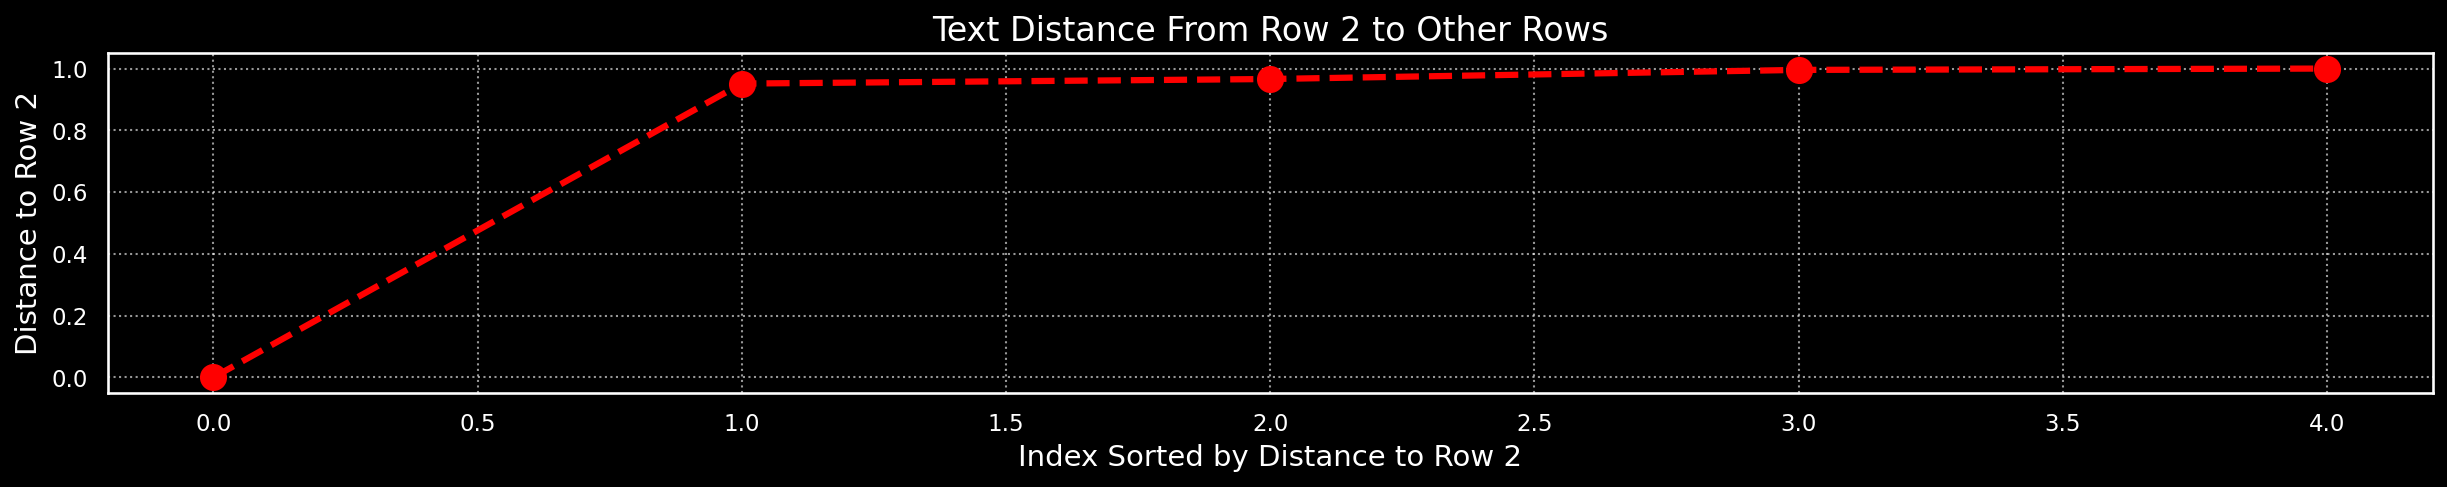

2         So what do you guys all do related to analytic...
268524              Do you guys have an interest in Kaggle?
106084               What do you guys do with the datasets?
113516    What do you guys want to do with machine learn...
524286                                                  ...
Name: title, dtype: object



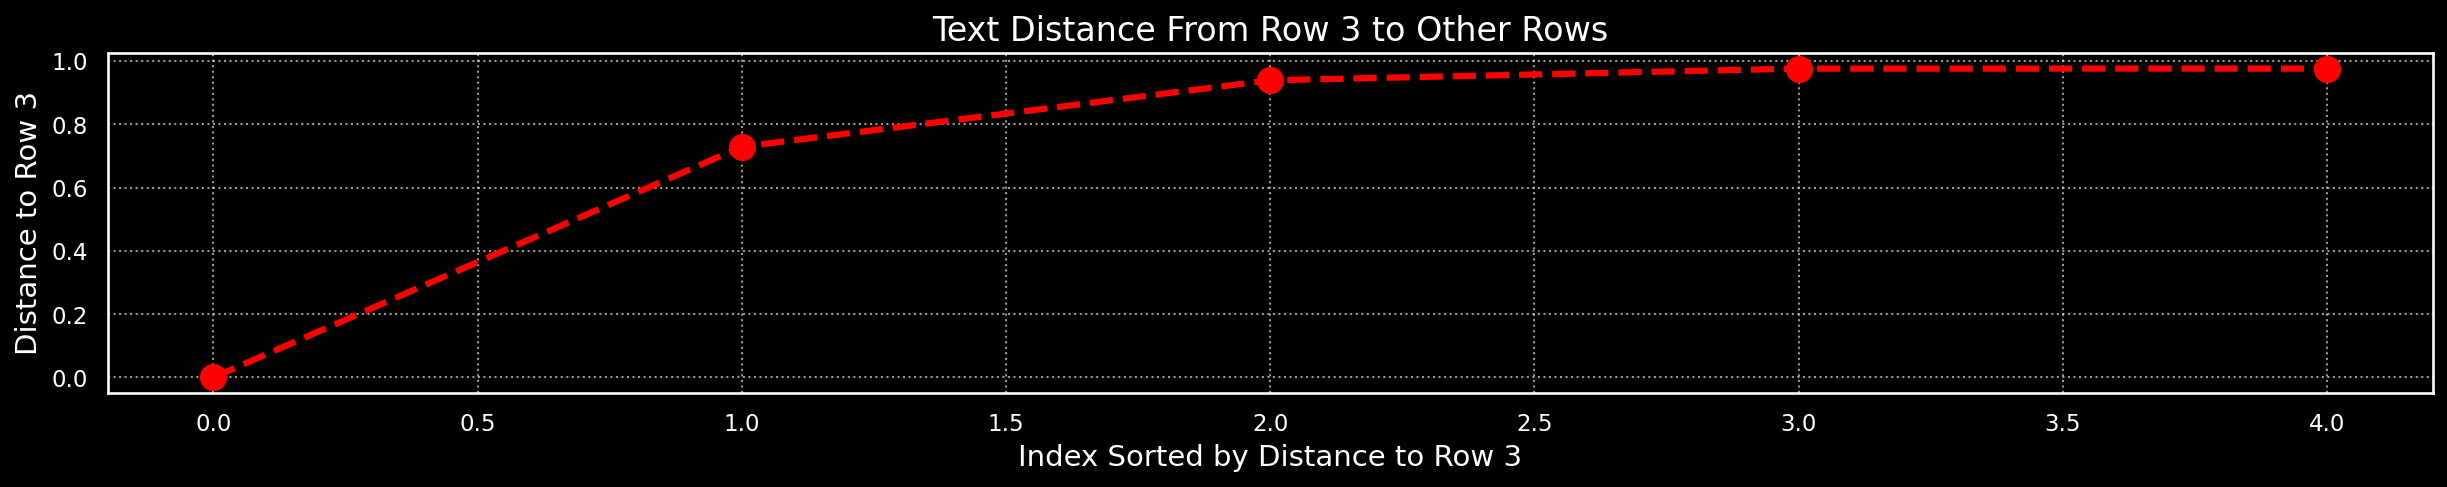

3       10 Web Analytics Tools For Tracking Your Visitors
9229                    [Tumblr Help] - Tracking Visitors
4285                          10 Best Web Analytics Tools
8826      Tracking web visitors who later convert offline
8660    Web analytics: Is there any generally accepted...
Name: title, dtype: object



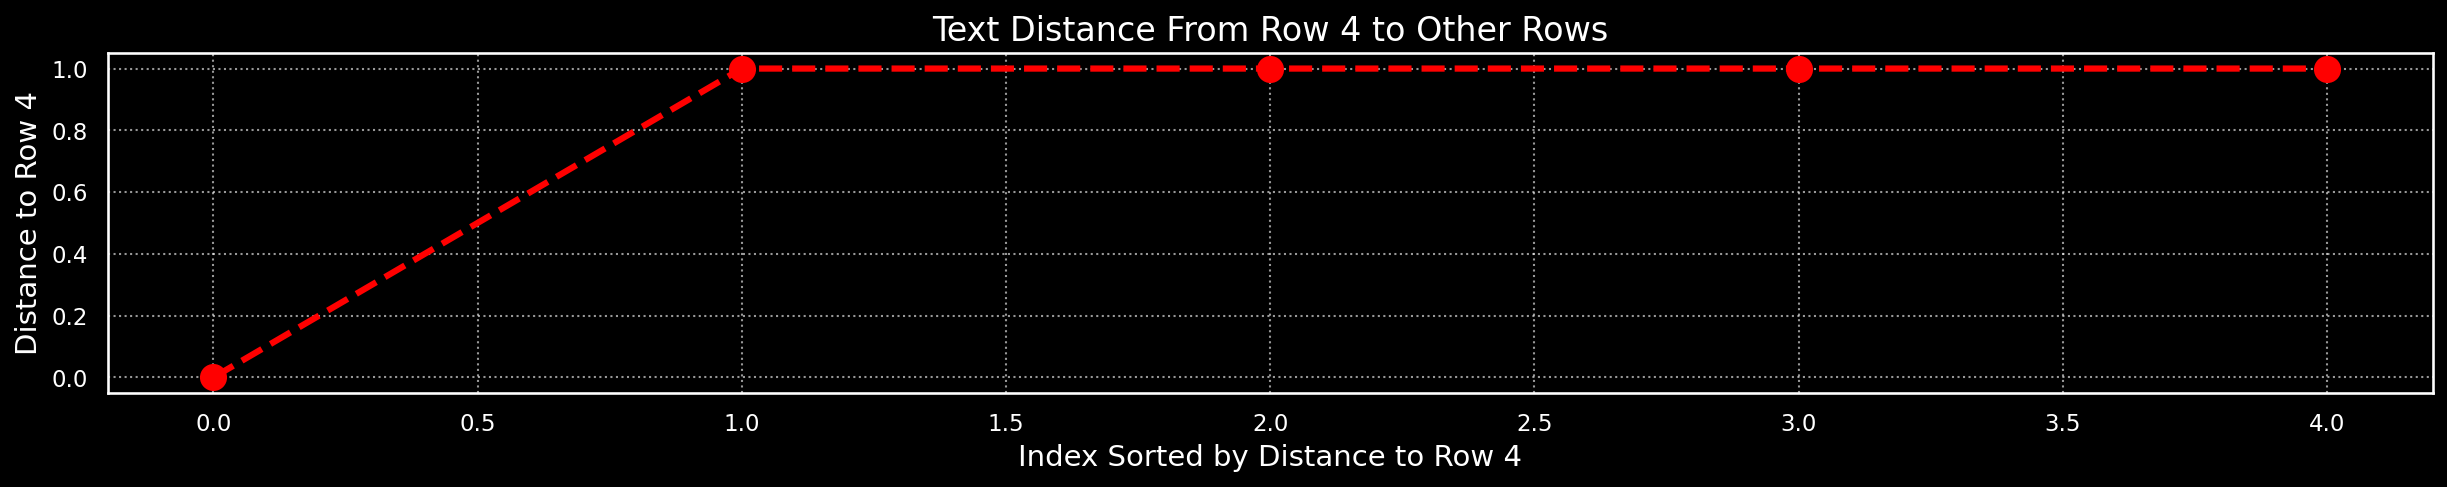

4                              Improving Your Sense of Site
524286                                                  ...
524748    https://filmi-beats.blogspot.com/2020/08/Haley...
525052                                         第三世多杰羌佛辦公室臉書
517571                                 30-seconds-of-r-code
Name: title, dtype: object



In [11]:
knn_viz(range(5), 5)

Fine! We see the same result as in the first notebook, only now on all data. Let's try to find similar posts for our test data.

In [12]:
# new corpus from created dictionary
corpus_bow = [dictionary.doc2bow(doc) for doc in test_posts]

# tfidf values from created tfidf model
corpus_tfidf = tfidf[corpus_bow]

# new sparse matrix
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms).T
corpus_tfidf_sparse

<2x101304 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

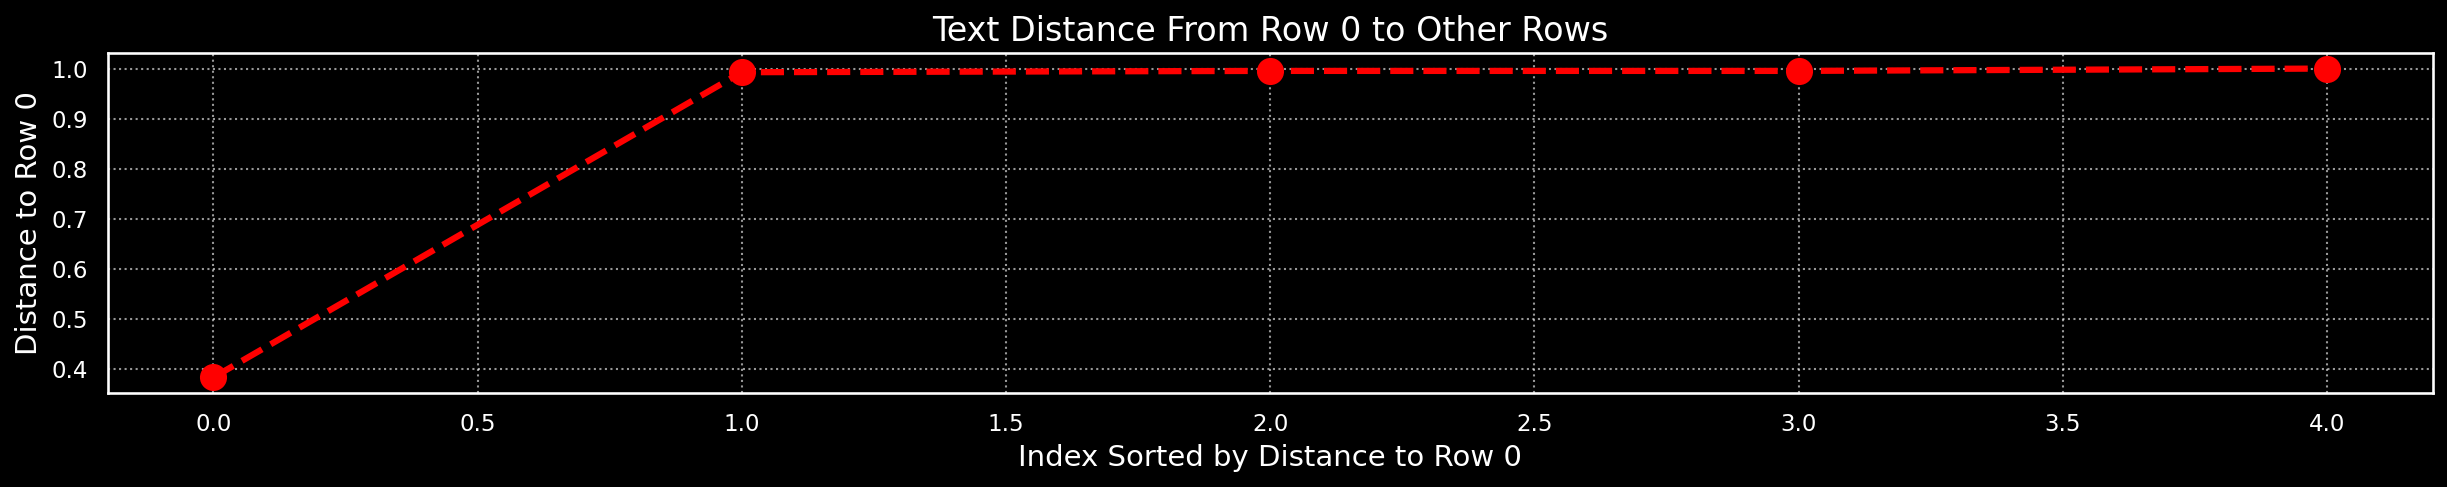

2         So what do you guys all do related to analytic...
268524              Do you guys have an interest in Kaggle?
64606                                               hi guys
273632                                              Hi Guys
524286                                                  ...
Name: title, dtype: object



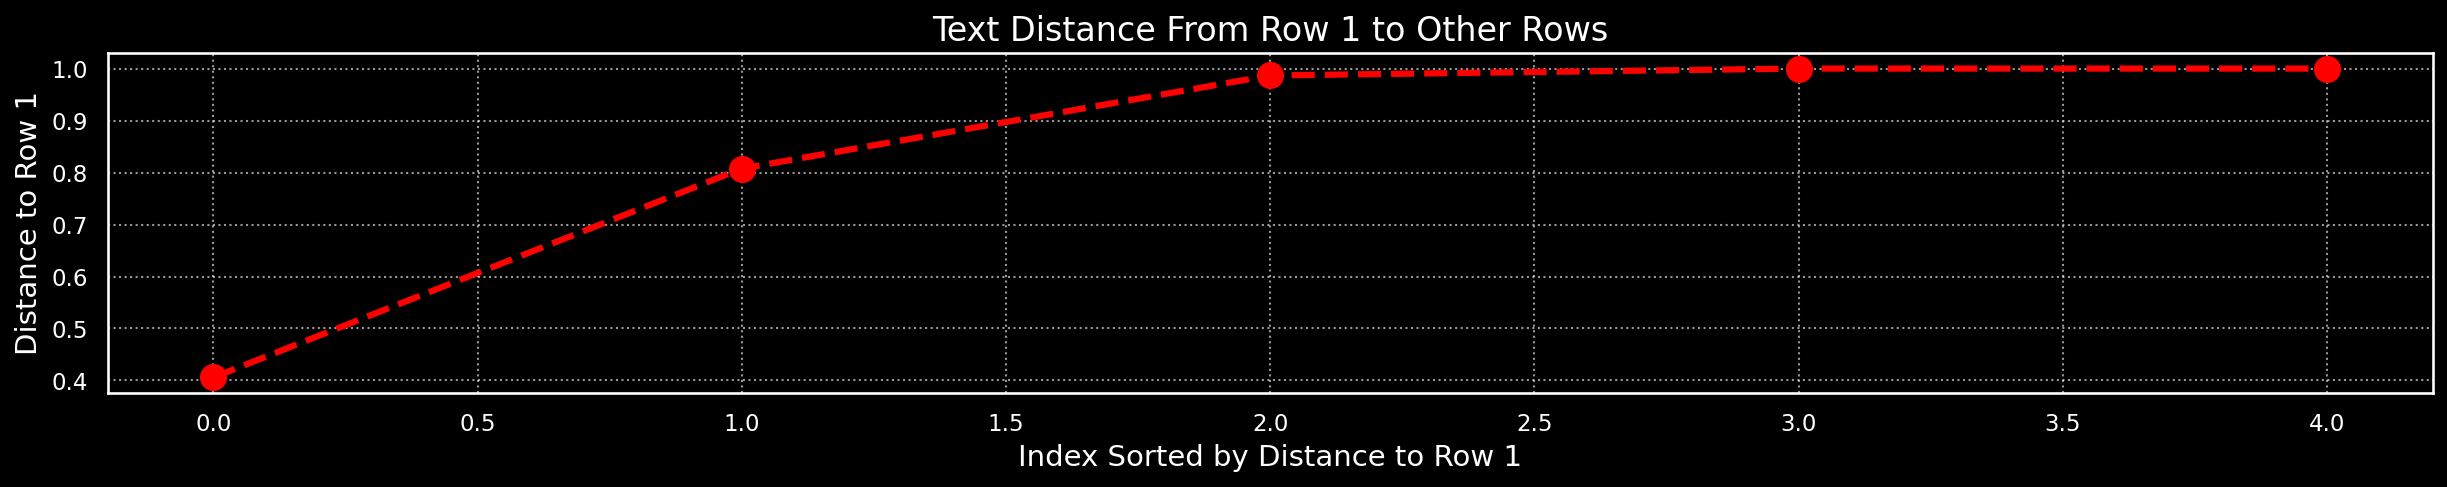

3         10 Web Analytics Tools For Tracking Your Visitors
9229                      [Tumblr Help] - Tracking Visitors
4285                            10 Best Web Analytics Tools
523122    בן ממשיך בנחלה -בתי המשפט לא נותנים תשובות - ב...
517571                                 30-seconds-of-r-code
Name: title, dtype: object



In [13]:
distances, indices = model.kneighbors(corpus_tfidf_sparse)
knn_viz(range(2), 5)

Great! It looks like everything is working as it should. Let's repeat the same for the posts themselves.

But before that, let's save the dictionary, tfidf model, and knn model. We still need them.

In [14]:
dictionary.save('TFIDF_dict_title')
tfidf.save('TFIDF_title')
dump(model, 'knn_title.model')

['knn_title.model']

# POST TEXTS

## Data preprocessing

In [15]:
post_cleaned = all_data['post'].dropna().reset_index(drop = True)
post_cleaned = post_cleaned.progress_apply(lambda x: text_cleaner(x).split())
post_cleaned

  0%|          | 0/262567 [00:00<?, ?it/s]

0         [theres, a, lot, of, reasons, to, want, to, kn...
1         [im, cross, posting, this, from, rcyberlaw, ho...
2         [dotceda, functional, analytics, consultant, o...
3         [here, is, the, program, details, of, the, dat...
4         [i, decided, grad, school, physics, was, not, ...
                                ...                        
262562    [i, have, a, dataset, with, a, group, variable...
262563    [i, have, wrote, a, very, long, convoluted, co...
262564    [ive, got, some, fake, data, that, i, want, to...
262565    [hi, folks, i, created, a, custom, function, s...
262566    [here, is, the, dputdf, output, for, the, data...
Name: post, Length: 262567, dtype: object

In [16]:
test_posts = post_cleaned[:2].copy()
test_posts.iloc[0] = test_posts.iloc[0][6:]
test_posts.iloc[1] = test_posts.iloc[1][6:]
test_posts

0    [want, to, know, all, this, stuff, so, i, figu...
1    [hopefully, you, guys, find, it, as, interesti...
Name: post, dtype: object

## TF-IDF Gensim

In [17]:
dictionary = Dictionary(post_cleaned)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

In [18]:
# the bag of words corpus
corpus_bow = [dictionary.doc2bow(doc) for doc in post_cleaned]

# tfidf
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [19]:
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms, num_docs=num_docs).T
corpus_tfidf_sparse

<262567x300126 sparse matrix of type '<class 'numpy.float64'>'
	with 18057213 stored elements in Compressed Sparse Row format>

## RAPIDS KNN

In [20]:
model = NearestNeighbors(n_neighbors = 5)
model.fit(corpus_tfidf_sparse)

distances, indices = model.kneighbors(corpus_tfidf_sparse)

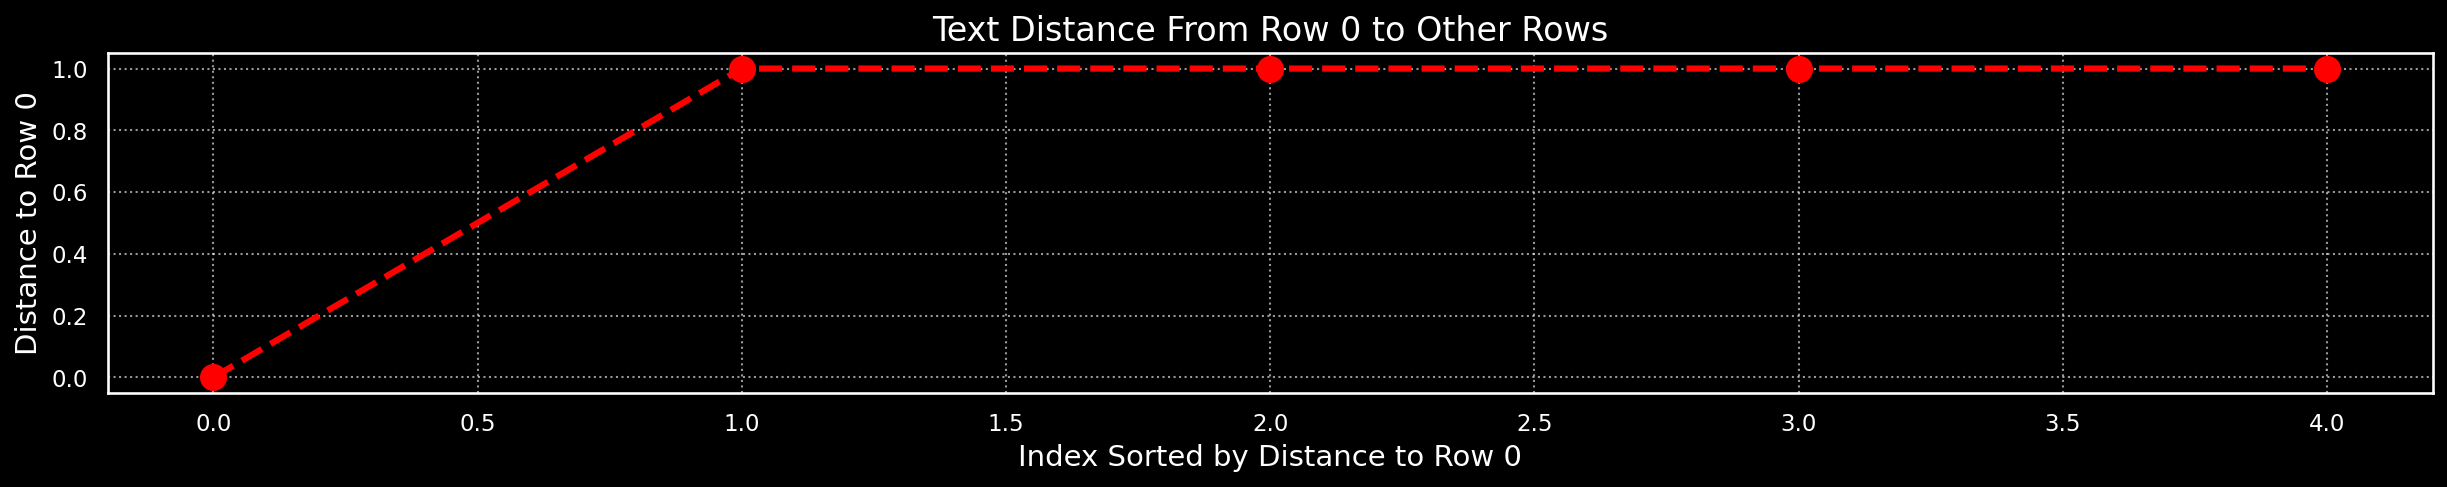

0               YouTube's traffic data for music questioned
260663                          Is this feasible for a FYP?
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
253846       Table detection and transformation from images
Name: title, dtype: object



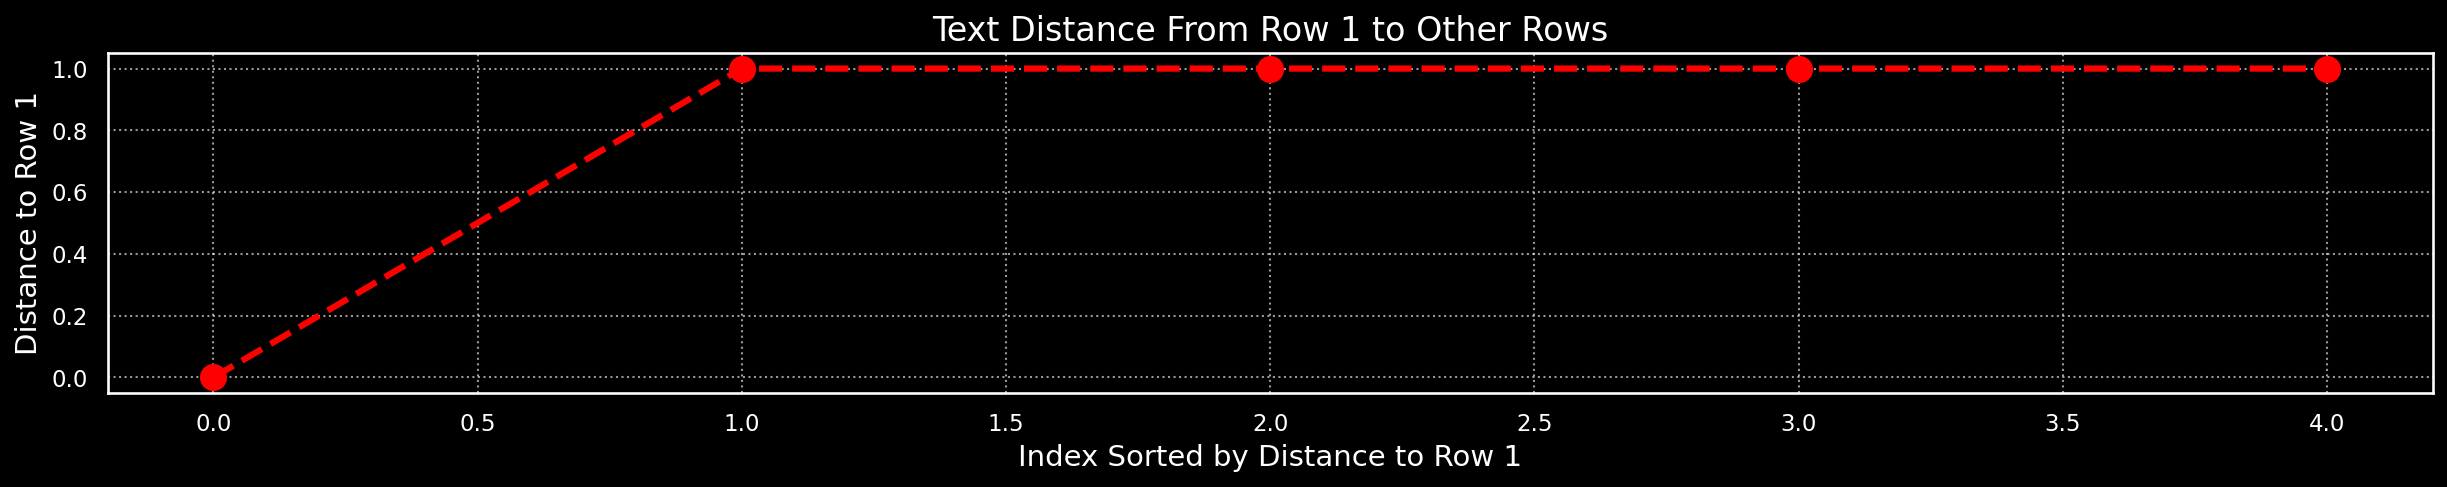

1         November Sees Number of U.S. Videos Viewed Onl...
260004    [R] Hierarchical Conditional Relation Networks...
261538    [D] Paper Explained - Training more effective ...
260539    [N] Last Week in AI News Digest - guidelines f...
260663                          Is this feasible for a FYP?
Name: title, dtype: object



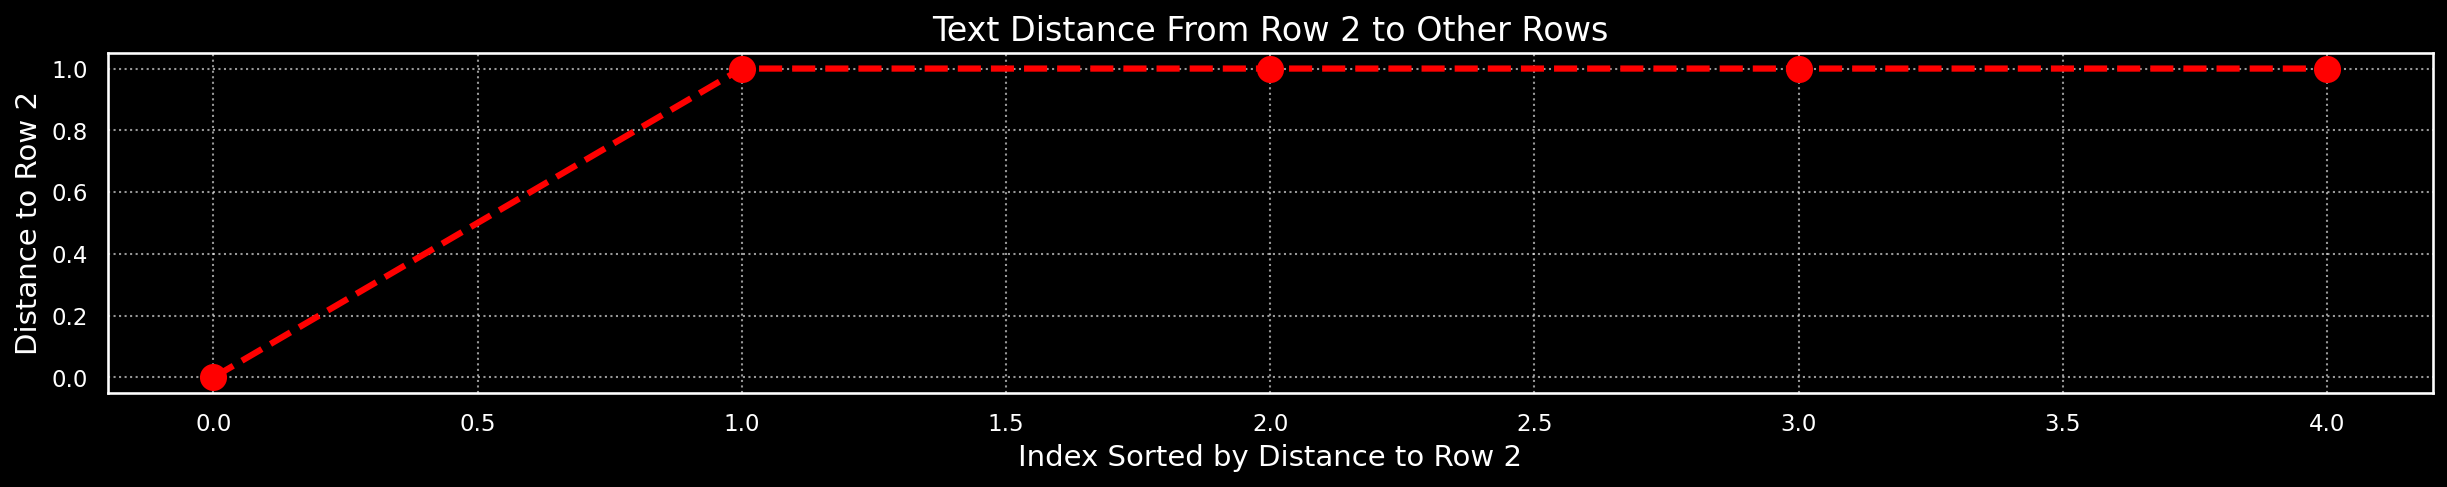

2         So what do you guys all do related to analytic...
260663                          Is this feasible for a FYP?
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
255770    What should I do after Andrew Ng’s 11 week lon...
Name: title, dtype: object



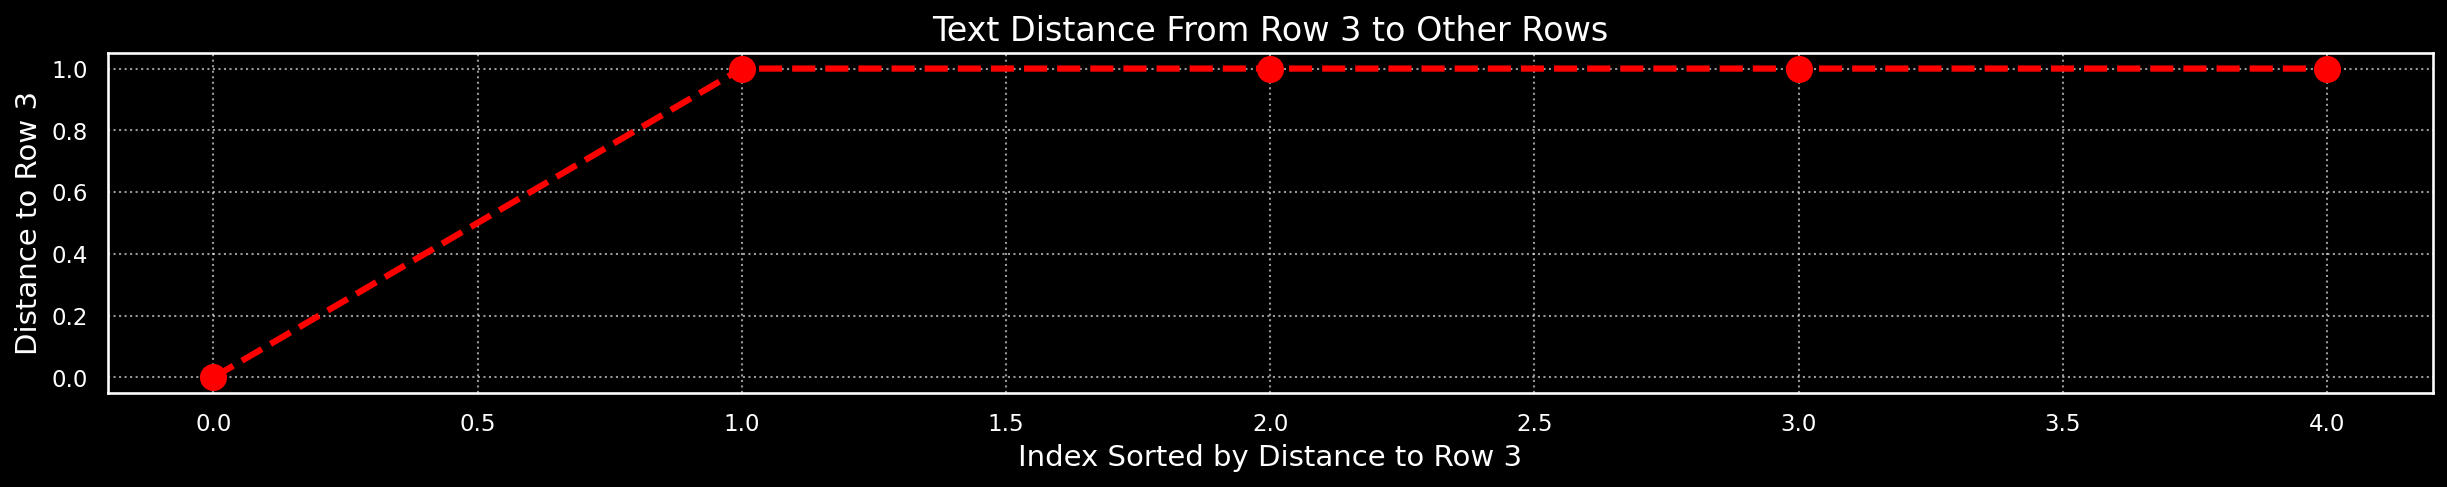

3         10 Web Analytics Tools For Tracking Your Visitors
260663                          Is this feasible for a FYP?
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
256041       [D] How do Ride Sharing companies predict ETA?
Name: title, dtype: object



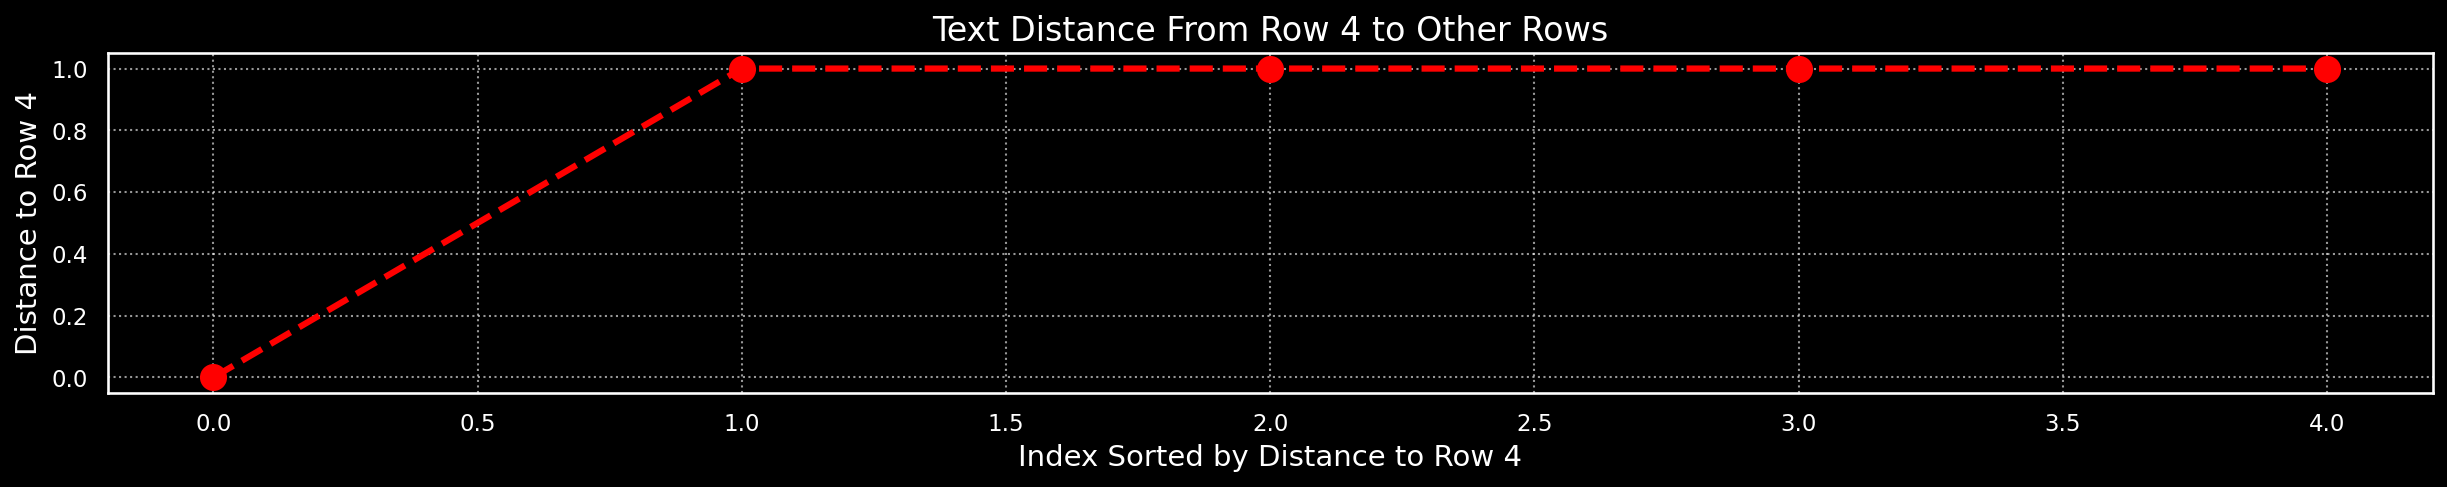

4                              Improving Your Sense of Site
256041       [D] How do Ride Sharing companies predict ETA?
256303    [P] Automatically migrate your project from DV...
250792    @people in the industry, what is your data wor...
240017          Can we train a model having only 1 entity ?
Name: title, dtype: object



In [21]:
knn_viz(range(5), 5)

In [22]:
# new corpus from created dictionary
corpus_bow = [dictionary.doc2bow(doc) for doc in test_posts]

# tfidf values from created tfidf model
corpus_tfidf = tfidf[corpus_bow]

# new sparse matrix
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms).T
corpus_tfidf_sparse

<2x300126 sparse matrix of type '<class 'numpy.float64'>'
	with 244 stored elements in Compressed Sparse Row format>

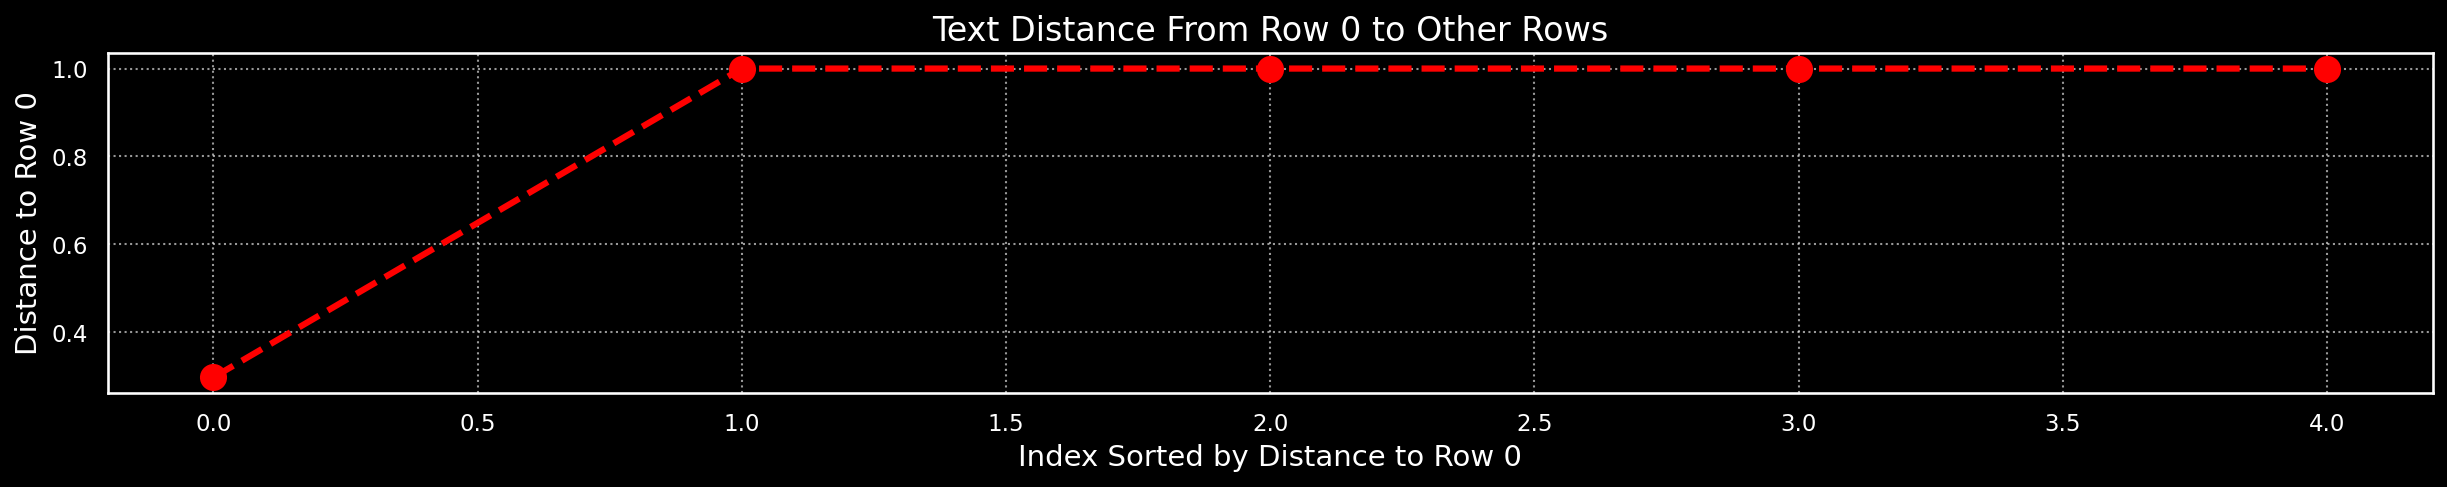

0               YouTube's traffic data for music questioned
260663                          Is this feasible for a FYP?
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
253846       Table detection and transformation from images
Name: title, dtype: object



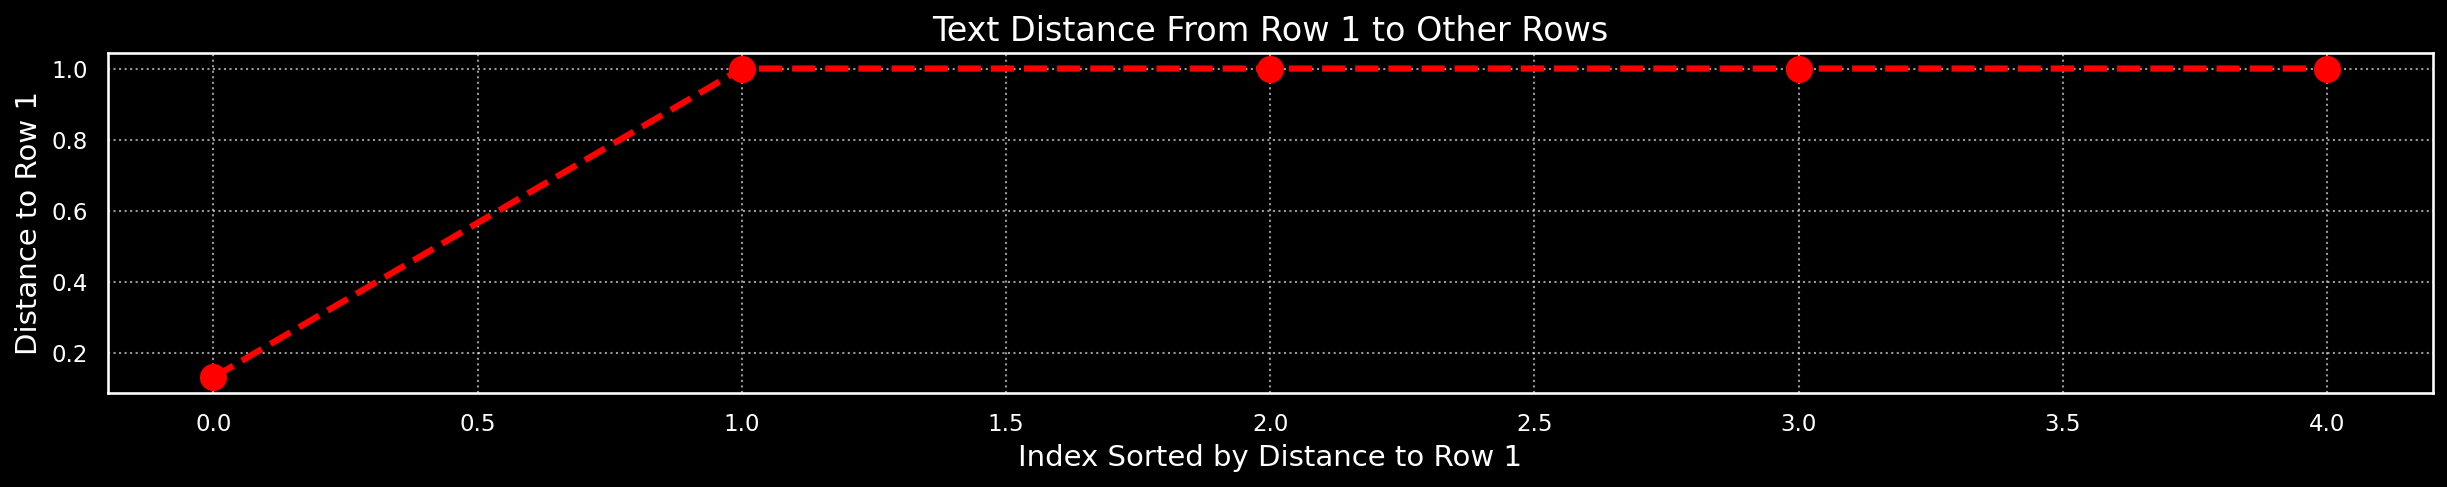

1         November Sees Number of U.S. Videos Viewed Onl...
261949    How to improve the classification performance ...
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
256041       [D] How do Ride Sharing companies predict ETA?
Name: title, dtype: object



In [23]:
distances, indices = model.kneighbors(corpus_tfidf_sparse)
knn_viz(range(2), 5)

The similarity of entire posts is a bit difficult to interpret at a glance without detailed comparison, but everything seems to work as it should. The algorithm found posts from which test samples were created with a very small distance.

Fine! Let's save the necessary objects and start creating our analyzer.

In [24]:
dictionary.save('TFIDF_dict_text')
tfidf.save('TFIDF_text')
dump(model, 'knn_text.model')

['knn_text.model']

# POST SIMILARITY ANALYZER

In [25]:
def similarity_analyzer(data, k_nearest = 5,
                        post_object = 'title'):
    assert post_object in {'title', 'text'}
    if k_nearest > 5:
        raise ValueError('"k_nearest" greater than 5!')
        
    if post_object == 'title':
        dictionary = Dictionary.load('./TFIDF_dict_title')
        tfidf = TfidfModel.load('./TFIDF_title')
        model = load('./knn_title.model')
        num_terms = len(dictionary.keys())
    elif post_object == 'text':
        dictionary = Dictionary.load('./TFIDF_dict_text')
        tfidf = TfidfModel.load('./TFIDF_text')
        model = load('./knn_text.model')
        num_terms = len(dictionary.keys())
    
    data_tokenized = data.progress_apply(lambda x: text_cleaner(x).split())
    
    corpus_bow = [dictionary.doc2bow(doc) for doc in data_tokenized]
    corpus_tfidf = tfidf[corpus_bow]
    corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms).T
    
    distances, indices = model.kneighbors(corpus_tfidf_sparse)
    return distances[:, :k_nearest], indices[:, :k_nearest]

  0%|          | 0/2 [00:00<?, ?it/s]

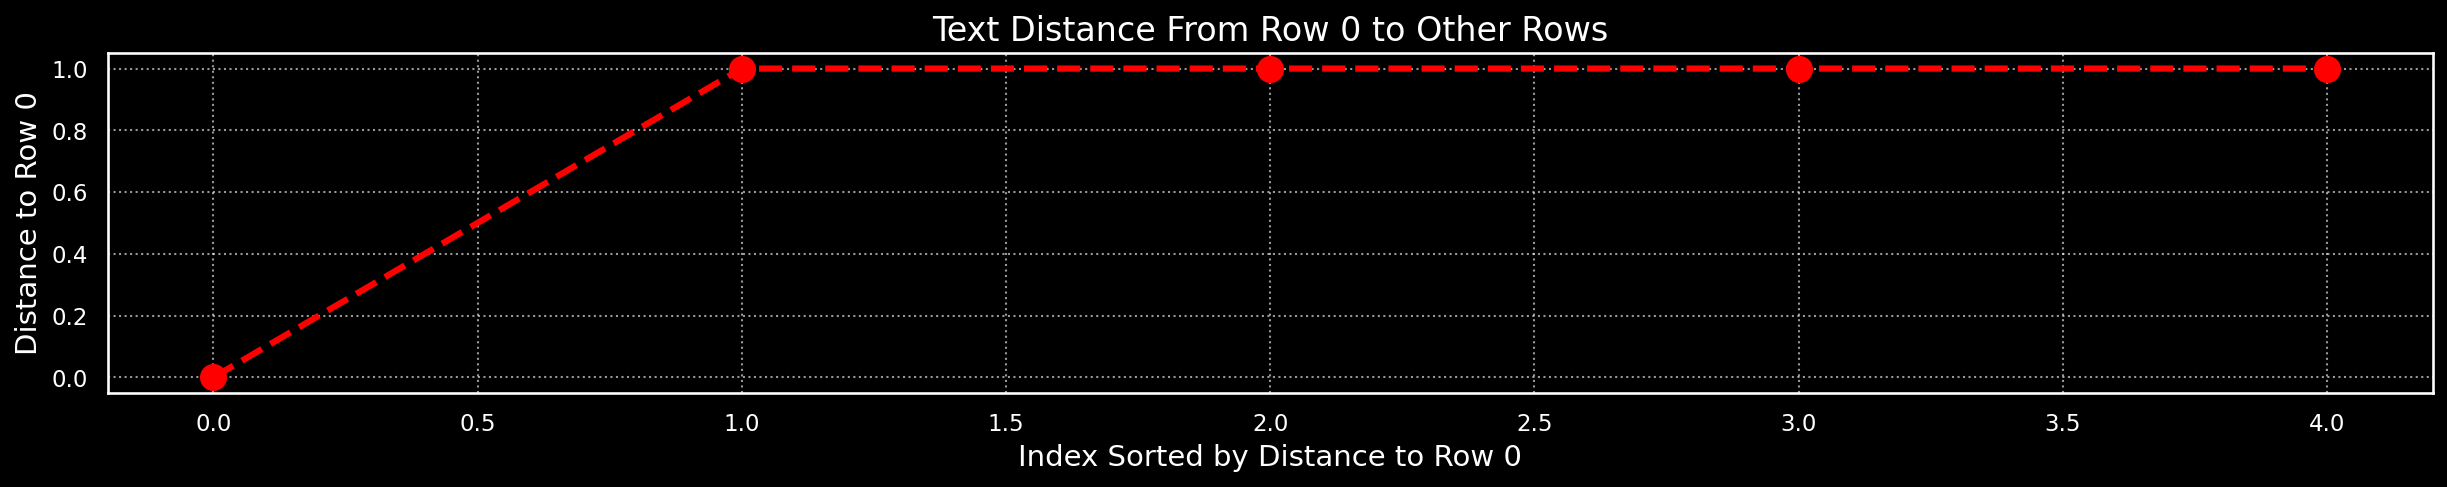

0               YouTube's traffic data for music questioned
260663                          Is this feasible for a FYP?
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
253846       Table detection and transformation from images
Name: title, dtype: object



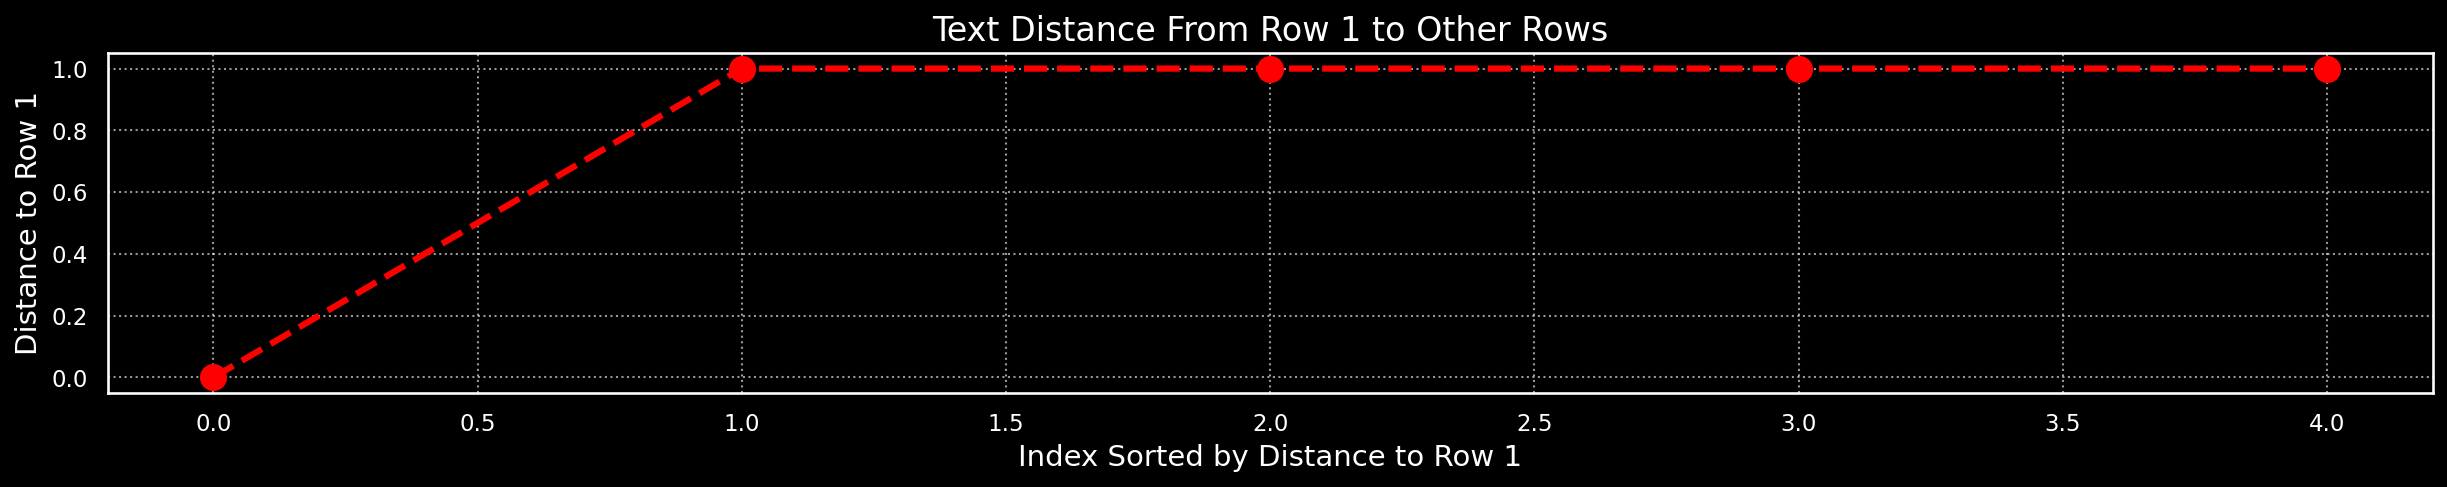

1         November Sees Number of U.S. Videos Viewed Onl...
260663                          Is this feasible for a FYP?
260004    [R] Hierarchical Conditional Relation Networks...
260539    [N] Last Week in AI News Digest - guidelines f...
231178    [N] Pytorch hackathon at Facebook. Aug 8th - A...
Name: title, dtype: object



In [26]:
K = 5
test_posts = all_data['post'].dropna().reset_index(drop = True)[:2]
distances, indices = similarity_analyzer(test_posts, 
                                         k_nearest = K,
                                         post_object = 'text')
knn_viz(range(2), K)

  0%|          | 0/2 [00:00<?, ?it/s]

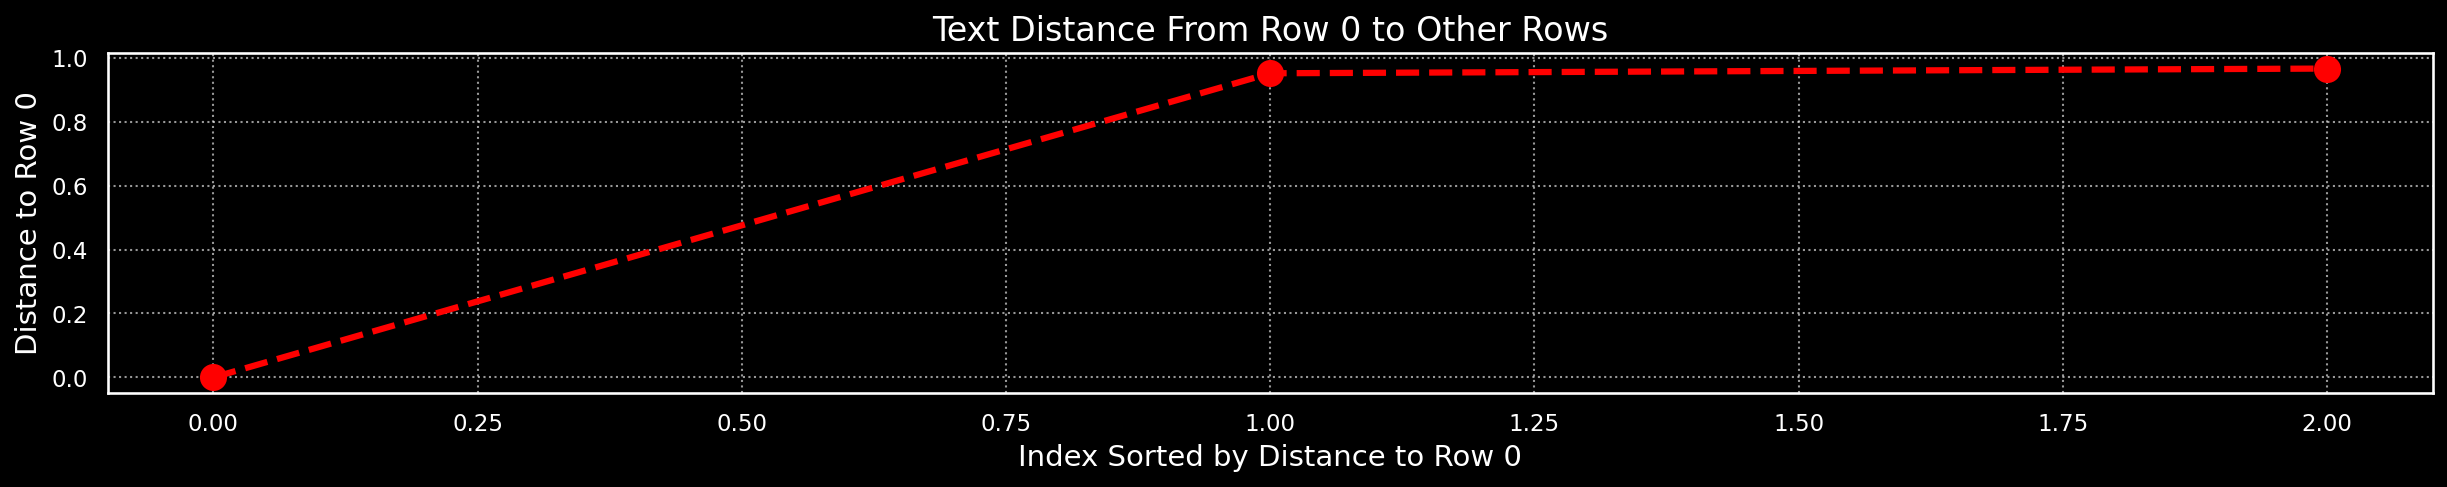

2         So what do you guys all do related to analytic...
268524              Do you guys have an interest in Kaggle?
106084               What do you guys do with the datasets?
Name: title, dtype: object



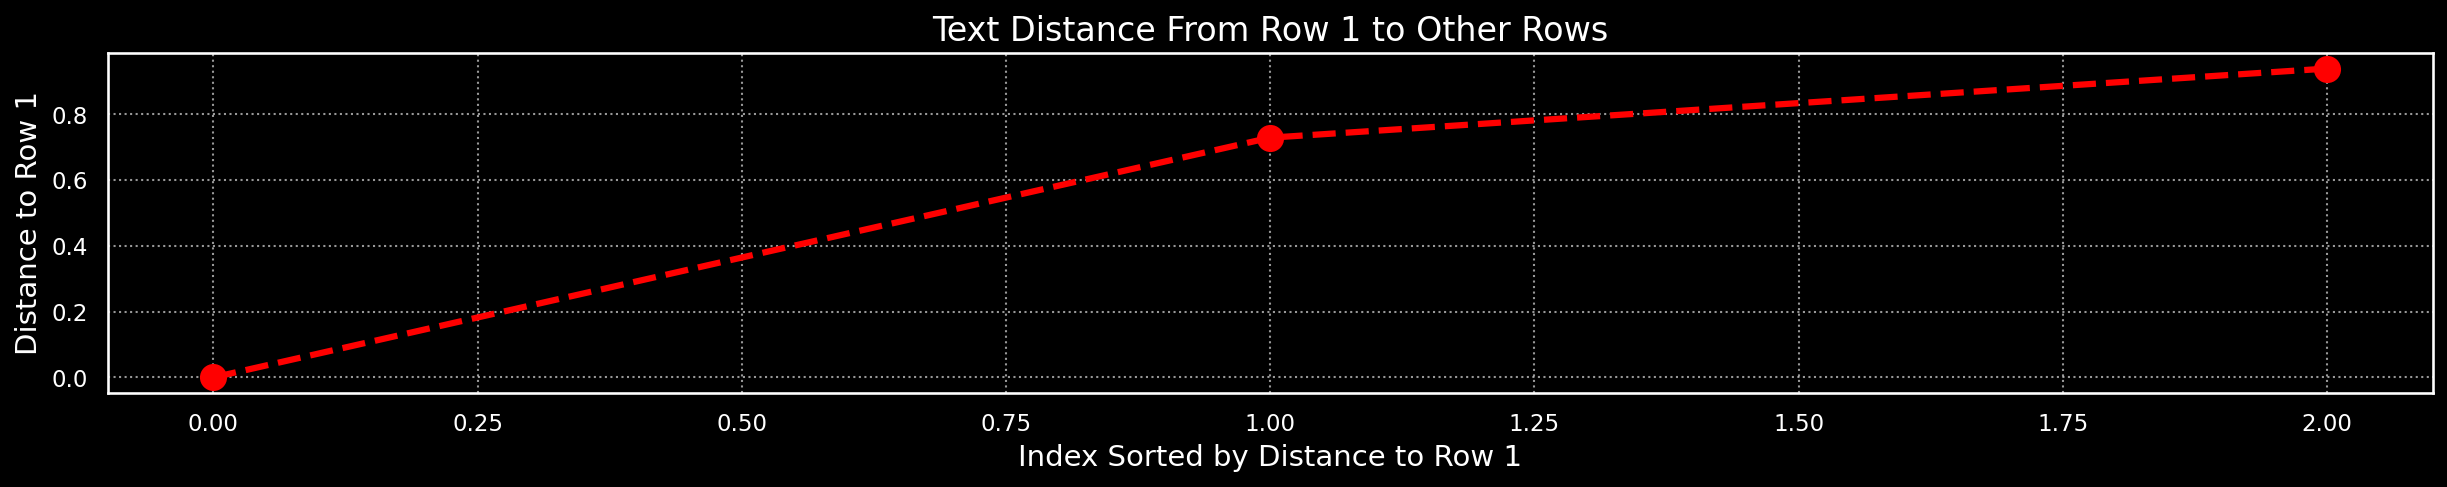

3       10 Web Analytics Tools For Tracking Your Visitors
9229                    [Tumblr Help] - Tracking Visitors
4285                          10 Best Web Analytics Tools
Name: title, dtype: object



In [27]:
K = 3
test_posts = all_data['title'].dropna().reset_index(drop = True)[2:4]
distances, indices = similarity_analyzer(test_posts, 
                                         k_nearest = K,
                                         post_object = 'title')
knn_viz(range(2), K)

Excellent! We have written an analyzer that checks the uniqueness of the title or text of a new post against the existing database.

This is a fairly simple, not the best, but powerful approach. The analyzer can be extended by adding additional parameters, for example, the similarity threshold, or can be rewritten to return the text itself, rather than the distance values and indices. The space for imagination is huge!

This is not the end of my work. In the future, I will try to improve the results, for example by better data cleaning, or by using other algorithms. Before that I experimented with `word2vec` and `doc2vec` models, and, to be honest, I am a little disappointed with their instability and poor results for this task. Maybe I was doing something wrong. I would be grateful if someone proves that I am wrong and posts good working `word2vec` and `doc2vec` models for this dataset.

If you enjoyed this work, please leave your opinion in the comments or upvoted. 
Also, If you are interested, see
- [this dataset (Reddit Data Science Posts)](https://www.kaggle.com/maksymshkliarevskyi/reddit-data-science-posts) 
- [first notebook (How is Data Science on Reddit? (EDA, RAPIDS))](https://www.kaggle.com/maksymshkliarevskyi/how-is-data-science-on-reddit-eda-rapids#RAPIDS-and-post-title).

**Good luck!**

<h2 style='color:white; background:black; border:0'><center>Work in progress...</center></h2>